# Figure 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import pearsonr

In [2]:
from plottable import Table, ColumnDefinition
from plottable.plots import bar
from plottable.cmap import normed_cmap, centered_cmap

## Settings

In [3]:
TEXT_WIDTH = 6.7261  # in
DPI = 360

In [4]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [5]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

## Load Data

In [6]:
dict_replace = {
    'concat': 'Concat',
    'moe': 'mvTCR',
    'moe_beta': 'mvTCR',
    'poe': 'PoE',
    'tcr': 'TCR',
    'rna': 'RNA',
    'mvTCR supervised': 'Sup-Class',
    'mvTCR supervised + kNN': 'Sup-Repr',
    
    
    'Prediction test': 'F1-Score',
    'NMI_cell_type': 'Cell Type',
    'NMI_celltype': 'Cell Type',
    'NMI_clonotype': 'Clonotype',
    
    'MSLE_total': 'MSLE', 
    'R2_total': 'R2',
    
    'None': '10x Full',
    'full': '10x Full',
    '-': 'Minervina',
    '1': 'D1',
    '2': 'D2',
    '3': 'D3',
    '4': 'D4',
    'donor_1': 'D1',
    'donor_2': 'D2',
    'donor_3': 'D3',
    'donor_4': 'D4',
    
    'minervina': 'Minervina',
    'haniffa': 'SARS',
    'Haniffa': 'SARS',
    'covid': 'Fischer',
    'Borcherding': 'TIL',
    'borcherding': 'TIL',
}

### Results Specificity

In [7]:
metrics_spec = ['Prediction test', 'NMI']
data_10x = pd.read_csv(f'../results/performance_10x.csv', index_col=0)
data_10x = data_10x[data_10x['metric'].isin(metrics_spec)]
data_10x.replace(dict_replace, inplace=True)

In [8]:
data_min = pd.read_csv(f'../results/performance_minervina.csv', index_col=0)
data_min = data_min[data_min['metric'].isin(metrics_spec)]
data_min.replace(dict_replace, inplace=True)

In [9]:
data_10x_missing = pd.read_csv(f'../results/performance_10x_missing.csv', index_col=0)
data_10x_missing = data_10x_missing[data_10x_missing['metric'].isin(metrics_spec)]
data_10x_missing.replace(dict_replace, inplace=True)
data_10x_missing.replace({'mvTCR': 'mvTCR--'}, inplace=True)
df_tmp = data_10x[data_10x['donor']=='10x Full']
df_tmp = df_tmp[df_tmp['model'].isin(['mvTCR', 'RNA', 'TCR'])]
data_10x_missing = pd.concat([data_10x_missing, df_tmp])

In [10]:
data_10x_sup = pd.read_csv(f'../results/performance_10x_supervised.csv', index_col=0)
data_10x_sup = data_10x_sup[data_10x_sup['metric'].isin(metrics_spec)]
data_10x_sup.replace(dict_replace, inplace=True)
data_min_sup = pd.read_csv(f'../results/performance_minervina_supervised.csv', index_col=0)
data_min_sup = data_min_sup[data_min_sup['metric'].isin(metrics_spec)]
data_min_sup['donor'] = 'minervina'
data_min_sup.replace(dict_replace, inplace=True)

data_sup = pd.concat([data_10x_sup, data_min_sup])
data_sup.loc[data_sup['metric']=='NMI', 'model'] = 'Sup-Repr'

In [11]:
data_spec = pd.concat([data_10x, data_min, data_sup])

### Results Preservance

In [12]:
data_char = pd.read_csv('../results/performance_perservance.csv', index_col=0)
data_char.replace(dict_replace, inplace=True)

In [13]:
def normalize_score(data, row):
    score = row[1]['score']

    normalizing_method = 'TCR'
    if row[1]['metric'] == 'Cell Type':
        normalizing_method = 'RNA'
    
    normalizing_row = data[(data['split']==row[1]['split']) 
                          & (data['model']==normalizing_method)
                          & (data['metric']==row[1]['metric'])
                          & (data['dataset']==row[1]['dataset'])].iloc[0]
    normalizing_score = normalizing_row['score']  
    return score / normalizing_score

data_char_norm = data_char.copy()
data_char_norm['score'] = [normalize_score(data_char_norm, el) for el in data_char_norm.iterrows()]

### Results Data Size

In [14]:
metrics_spec = ['Prediction test', 'NMI']
data_size = pd.read_csv(f'../results/performance_10x_datasize.csv', index_col=0)
data_size_min = pd.read_csv(f'../results/performance_minervina_datasize.csv', index_col=0)
data_size = pd.concat([data_size, data_size_min])
data_size = data_size[data_size['metric'].isin(metrics_spec)]
data_size['donor'] = data_size['donor'].astype(str)
data_size.replace(dict_replace, inplace=True)
data_size = data_size.reset_index()

### Results SOTA - Specificity

In [15]:
data_sota_spec = pd.read_csv('../results/performance_10x_beta.csv', index_col=0)
data_sota_tessa = pd.read_csv('../results/performance_tessa_10x.csv', index_col=0)
data_sota_min = pd.read_csv('../results/performance_minervina_beta.csv', index_col=0)
data_sota_min['donor'] = 'Minervina'
data_sota_min_tessa = pd.read_csv('../results/performance_tessa_minervina.csv', index_col=0)
data_sota_min_tessa['donor'] = 'Minervina'
data_sota_spec = pd.concat([data_sota_spec, data_sota_tessa, data_sota_min, data_sota_min_tessa])
data_sota_spec.replace(dict_replace, inplace=True)
#data_sota_spec.replace({'mvTCR': 'mvTCR-β'}, inplace=True)

### Results SOTA - Cell characteristics

In [16]:
data_sota_char = pd.read_csv('../results/performance_perservance_beta.csv', index_col=0)
data_sota_tessa = pd.read_csv('../results/performance_tessa_characteristics.csv', index_col=0)
data_sota_char = pd.concat([data_sota_char, data_sota_tessa])
data_sota_char.replace(dict_replace, inplace=True)
#data_sota_char.replace({'mvTCR': 'mvTCR-β'}, inplace=True)

### Results Avidity

In [17]:
data_avidity = pd.read_csv('../results/performance_avidity_10x.csv', index_col=0)

for old, new in dict_replace.items():
    data_avidity.replace(old, new, inplace=True)
data_avidity['epitope'] = data_avidity['metrics'].str.split('_').str[2]
data_avidity['metric'] = data_avidity['metrics'].str.split('_').str[0]
data_avidity['score'] = data_avidity['scores']

### Results Contribution

In [18]:
results_contributions = pd.read_csv(f'../results/contribution_10x_minervina.csv', index_col=0)
results_contributions = results_contributions.replace(dict_replace)
results_contributions = results_contributions.rename(columns={'score': 'Contribution Score'})

results_10x_rna = data_spec[(data_spec['model']=='RNA') & (data_spec['metric']=='F1-Score')]
results_10x_rna = results_10x_rna.sort_values(['donor', 'split'])

results_10x_tcr = data_spec[(data_spec['model']=='TCR') & (data_spec['metric']=='F1-Score')]
results_10x_tcr = results_10x_tcr.sort_values(['donor', 'split'])

results_contributions = results_contributions.sort_values(['donor', 'split'])
results_contributions['F1_rna'] = results_10x_rna['score'].values
results_contributions['F1_tcr'] = results_10x_tcr['score'].values

results_contributions['F1(TCR)/F1(RNA)'] = results_contributions['F1_tcr'] / results_contributions['F1_rna']

In [19]:
pearsonr(results_contributions['Contribution Score'].values, results_contributions['F1(TCR)/F1(RNA)'].values)
pearsonr(results_contributions['Contribution Score'].values, results_contributions['F1(TCR)/F1(RNA)'].values)

PearsonRResult(statistic=0.7574768196278721, pvalue=1.2586919824038965e-06)

## Results compactness

In [20]:
results_compactness = pd.read_csv(f'../results/ct_compactness_10x_minervina.csv', index_col=0)
results_compactness = results_compactness.replace(dict_replace)
results_compactness = results_compactness.rename(columns={'score': 'GEX Distance'})

results_compactness['Contribution Score'] = results_contributions[results_contributions['donor']!='Minervina'
                                                                 ]['Contribution Score']
results_compactness = results_compactness.groupby(['donor']).mean()
results_compactness = results_compactness.reset_index()

### Statistical Testing

In [21]:
from scipy.stats import ttest_rel
def get_p_values(df_perf, baselines, comp_modes=None, sortby=None):
    dfs = []
    
    for baseline in baselines:
        pvals = []
        models = []
        metrics = []
        for metric in df_perf['metric'].unique():
            df_tmp = df_perf[df_perf['metric']==metric]        
            df_left = df_tmp[df_tmp['model']==baseline].copy()
            df_left = df_left.sort_values(sortby)
            x_left = df_left['score'].values
            
            for model in df_perf['model'].unique():
                df_right = df_tmp[df_tmp['model']==model].copy()
                df_right = df_right.sort_values(sortby)
                x_right = df_right['score'].values
                
                p = ttest_rel(x_left, x_right, alternative='less' if metric!='MSLE' else 'greater')[1]
                
                pvals.append(p)
                models.append(model)
                metrics.append(metric)
        df = pd.DataFrame({'model': models, 'metric': metrics, baseline: pvals})
        dfs.append(df)
    if len(dfs) > 1:
        return  pd.merge(*dfs, on=['model', 'metric'], how='left')
    return dfs[0]

p_values_spec = get_p_values(data_spec[~data_spec['model'].str.contains('Sup')], 
                                       baselines=['RNA', 'TCR'], sortby=['donor', 'split'])
p_values_avd = get_p_values(data_avidity, baselines=['RNA', 'TCR'], sortby=['donors', 'split'])
p_values_sota_spec = get_p_values(data_sota_spec, baselines=['tessa'], sortby=['donor', 'split'])
p_values_char = {dataset: get_p_values(data_char_norm[data_char_norm['dataset']==dataset], 
                                       baselines=['RNA', 'TCR'], sortby=['dataset'])
                 for dataset in data_char_norm['dataset'].unique()}
dfs = []
for dataset, df in p_values_char.items():
    df['dataset'] = dataset
    dfs.append(df)
p_values_char = pd.concat(dfs)

p_values_char_sota = {dataset: get_p_values(data_sota_char[data_sota_char['dataset']==dataset], 
                                       baselines=['tessa', 'mvTCR'], sortby=['dataset'])
                 for dataset in data_sota_char['dataset'].unique()}
dfs = []
for dataset, df in p_values_char_sota.items():
    df['dataset'] = dataset
    dfs.append(df)
p_values_char_sota = pd.concat(dfs)

In [22]:
p_values_char = get_p_values(data_char_norm, 
                             baselines=['RNA', 'TCR'], sortby=['dataset', 'split'])
p_values_char

,model,metric,RNA,TCR
0,mvTCR,Cell Type,9.999999e-01,7.517846e-06
1,TCR,Cell Type,9.999998e-01,NaN
2,RNA,Cell Type,NaN,1.640469e-07
3,Concat,Cell Type,9.998442e-01,5.418031e-06
4,PoE,Cell Type,9.999722e-01,3.497541e-05
5,mvTCR,Clonotype,1.469006e-07,9.119241e-01
6,TCR,Clonotype,1.815473e-04,NaN
7,RNA,Clonotype,NaN,9.998185e-01
8,Concat,Clonotype,2.476355e-05,9.187855e-01
9,PoE,Clonotype,6.620424e-06,8.207328e-01


In [23]:
def p_2_sign(val):
    if val == -99:
        return ''
    if val < 0.001:
        return '***'
    if val < 0.01:
        return '**'
    if val < 0.05:
        return '*'
    else:
        return ''

## Plotting functions

In [24]:
def plot_empty(ax):
    ax.axis('off')

### Plot Table

### Boxplots

In [25]:
def plot_boxplot(data, models, p_values, ax, ylabel='Specificity', do_legend=False, scatter=False):
    data_tmp = data[data['model'].isin(models)].copy()
    data_tmp['model'] = data_tmp['model'].astype(str)
    plot = sb.barplot(data=data_tmp, x='metric', y='score', hue='model', 
                      hue_order=[el for el in order if el in models], palette=palette,
                      #fliersize=3, linewidth=0.75,
                      capsize=.2, errwidth=0.75,
                      ax=ax)

    if scatter:
        sb.swarmplot(data=data_tmp, x='metric', y='score', hue='model', 
                 size=2, dodge=True,
                 hue_order=[el for el in order if el in models], order=['F1-Score', 'NMI'],
                 alpha=0.75,
                 color='black',
                 ax=ax)
    
    """    for donor in data['donor'].unique():
        sb.swarmplot(data=data_tmp[data_tmp['donor']==donor], x='metric', y='score', hue='model', 
                     size=1.5, dodge=True,
                     hue_order=[el for el in order if el in models], 
                     palette=[donor_colors[donor]]*len(models),
                     alpha=0.75,
                     ax=ax)"""
    plot.set(xlabel=None)
    ax.set_ylabel(ylabel, labelpad=0)
    ax.get_legend().remove()
    ax.tick_params('y', pad=-3)
        
    label_locs = ax.get_xticks()
    label_names = [el.get_text() for el in ax.get_xticklabels()]
    labels = dict(zip(label_names, label_locs)) 
    bar_width = 0.8 / len(models)
    
    y_pos = ax.get_ylim()[1]*1.03
    
    if p_values is not None:
        baseline_cols = [el for el in p_values.columns if el not in ['score', 'model', 'metric']]

        for met in data['metric'].unique():
            for mod in models:
                p_signs = []
                p_tmp = p_values[(p_values['metric']==met) & (p_values['model']==mod)]
                for baseline in baseline_cols:
                    p = p_tmp[baseline].values
                    p_signs.append(p_2_sign(p))
                p_signs = '\n'.join(p_signs)

                x_pos = labels[met] + (models.index(mod)-len(models)/2+0.5)*bar_width# - len(models)//2*bar_width 
                ax.text(x_pos, y_pos, p_signs, size='medium', #weight='bold', 
                        linespacing=0.5,
                        verticalalignment='center', horizontalalignment='center')    

        x_pos = 0.03 - (len(models)/2) * bar_width
        if ylabel:
            ax.text(x_pos*1.1, y_pos*(1.08 if len(baseline_cols)==2 else 1.05), 
                    '\n'.join(baseline_cols), size='small', verticalalignment='top', 
                    horizontalalignment='center')
    ax.grid(False)
    sb.despine(ax=ax)
    

    if do_legend:      
        handles, labels = [(a + b) for a, b in zip(axes['a'].get_legend_handles_labels(), 
                                                   axes['e'].get_legend_handles_labels())]
        ax.legend(handles[:], labels[:], loc='upper center', ncol=6, bbox_to_anchor=(2, 1.25), frameon=False)

In [26]:
def plot_barplot(data, models, p_values, ax1, ax2):   
    ds_order = ['Fischer', 'SARS', 'TIL']
    for ax, metric, baseline in zip([ax1, ax2], ['Clonotype', 'Cell Type'], ['RNA', 'TCR']):
        models_tmp = [baseline] + models.copy()
        if len(models) > 1:
            models_tmp = models.copy()
        data_tmp = data[data['model'].isin(models_tmp)]
        data_tmp = data_tmp[data_tmp['metric']==metric].copy()
        data_tmp['model'] = data_tmp['model'].astype(str)
        plot = sb.barplot(data=data_tmp, x='dataset', y='score', hue='model', 
                          hue_order=[el for el in order if el in models_tmp], palette=palette,
                          order=ds_order,
                          capsize=.2, errwidth=0.75,
                          ax=ax)
        
        sb.swarmplot(data=data_tmp, x='dataset', y='score', hue='model', 
                     size=2, dodge=True,
                     hue_order=[el for el in order if el in models_tmp], order=ds_order,
                     alpha=0.75,
                     color='black',
                     ax=ax)
        
        ax.set_ylim(0, 1.1)
        ax.get_legend().remove()
        plot.set(xlabel=metric)
        
        if metric == 'Clonotype':
            ax.set_ylabel('Scaled NMI', labelpad=0)
            ax.tick_params('y', pad=-3)
            sb.despine(ax=ax)
        else:
            ax.set_ylabel(None)
            ax.set_yticklabels([])
            sb.despine(ax=ax, left=True)

        label_locs = ax.get_xticks()
        label_names = [el.get_text() for el in ax.get_xticklabels()]
        labels = dict(zip(label_names, label_locs)) 
        bar_width = 0.8 / len(models_tmp)

        y_pos = ax.get_ylim()[1]*1.03

        if p_values is not None:
            for d in ds_order:
                for mod in models_tmp:
                    p = p_values[(p_values['metric']==metric) 
                                 & (p_values['model']==mod)
                                 & (p_values['dataset']==d)][baseline].values

                    p_sign = p_2_sign(p)

                    x_pos = labels[d] + (models_tmp.index(mod)-len(models_tmp)/2+0.5)*bar_width# - len(models)//2*bar_width 
                    ax.text(x_pos, y_pos, p_sign, size='medium', #weight='bold', 
                            linespacing=0.5,
                            verticalalignment='center', horizontalalignment='center')    
        
            x_pos = 0.0 - (len(models)/2) * bar_width
            ax.text(x_pos, y_pos*1.04, baseline, size='small', verticalalignment='top', horizontalalignment='center')
        ax.grid(False)
        

In [27]:
def plot_barplot_tessa(data, models, p_values, metric, ax):   
    ds_order = ['Fischer', 'SARS', 'TIL']
    baseline = 'tessa'

    data_tmp = data[data['model'].isin(models)]
    data_tmp = data_tmp[data_tmp['metric']==metric].copy()
    plot = sb.barplot(data=data_tmp, x='dataset', y='score', hue='model', 
                      hue_order=[el for el in order if el in models], palette=palette,
                      order=ds_order,
                      capsize=.2, errwidth=0.75,
                      ax=ax)

    sb.swarmplot(data=data_tmp, x='dataset', y='score', hue='model', 
                 size=2, dodge=True,
                 hue_order=[el for el in order if el in models], order=ds_order,
                 alpha=0.75,
                 color='black',
                 ax=ax)

    #ax.set_ylim(0, 1.1)
    ax.get_legend().remove()
    plot.set(xlabel=metric)

    ax.set_ylabel('NMI Celltype', labelpad=0)
    ax.tick_params('y', pad=-3)
    sb.despine(ax=ax)

    label_locs = ax.get_xticks()
    label_names = [el.get_text() for el in ax.get_xticklabels()]
    labels = dict(zip(label_names, label_locs)) 
    bar_width = 0.8 / len(models)

    y_pos = ax.get_ylim()[1]*1.03
    
    for d in ds_order:
        for mod in models:
            p = p_values[(p_values['metric']==metric) 
                         & (p_values['model']==mod)
                         & (p_values['dataset']==d)][baseline].values

            p_sign = p_2_sign(p)

            x_pos = labels[d] + (models.index(mod)-len(models)/2+0.5)*bar_width# - len(models)//2*bar_width 
            ax.text(x_pos, y_pos, p_sign, size='medium', #weight='bold', 
                    linespacing=0.5,
                    verticalalignment='center', horizontalalignment='center')    

    x_pos = 0.0 - (len(models)/2) * bar_width
    ax.text(x_pos, y_pos*1.05, baseline, size='small', verticalalignment='top', horizontalalignment='center')
    ax.grid(False)
#plot_barplot_tessa(data_sota_char, ['mvTCR-β', 'tessa'], p_values_char_sota, 'Cell Type', axes['f'])

In [28]:
def plot_lineplot(data, ax, donors=None, metrics=['F1-Score']):
    for metric in metrics:
        data_tmp = data[data['metric']==metric]
        if donors is not None:
            data_tmp = data_tmp[data_tmp['donor'].isin(donors)].copy()
        data_tmp = data_tmp.copy()
        plot = sb.lineplot(data=data_tmp, x='size', y='score', #hue='donor', 
                           #palette=donor_colors,
                           color=sb.color_palette('deep')[1],
                           ax=ax)
    
    #ax.get_legend().remove()
    
    ax.set_xlabel('Training Size')
    #ax.set_xscale('log')
    ax.set_ylabel(metric, labelpad=0)
    ax.tick_params('y', pad=-3)
    ax.grid(False)
    sb.despine(ax=ax)

In [29]:
def plot_scatter_conservation(data, model, baseline, modality, ax, do_axis=True):
    data_tmp = data[data['metric']==modality]
    
    y = data_tmp[data_tmp['model']==model].sort_values(['dataset', 'split'])
    x = data_tmp[data_tmp['model']==baseline].sort_values(['dataset', 'split'])
    
    df_ = pd.DataFrame({baseline: x['score'].values, model: y['score'].values, 
                        'dataset': y['dataset'].values})
    plot = sb.scatterplot(data=df_, x=baseline, y=model, hue='dataset', ax=ax, 
                          s=10, palette=palette)
    
    ax.grid(False)
    sb.despine(ax=ax)
    
    
    offset = 0.7
    if modality=='Cell Type':
        offset = 0.25
    ax.plot([offset, 1], [offset, 1], linestyle='--', color='black', alpha=0.2, zorder=-1)
    
    if not do_axis:
        ax.set_ylabel('')
        ax.get_legend().remove()
    else:
        ax.set_ylabel(ax.get_ylabel(), labelpad=0)
        ax.legend(title=None, handletextpad=0.)
    ax.tick_params('y', pad=-3)
    ax.set_title(modality)
    
#plot_scatter(data_char_norm, 'mvTCR', 'RNA', 'Clonotype', None)

In [30]:
def plot_scatter(data, x, y, ax):
    corr_test = pearsonr(data[x].values, data[y].values)
    corr_test = pearsonr(data[x].values, data[y].values)
    plot = sb.regplot(data=data, x=x, y=y, scatter=False, ax=ax, 
                      line_kws={'zorder': -1, 'linewidth': 1, 'color': color_regplot})
    sb.scatterplot(data=data, x=x, y=y, hue='donor', ax=ax, size=1.5, zorder=1, palette=donor_colors)

    print(corr_test)
    plot.set_title(f'Pearson r: {corr_test[0]:.2f} ({p_2_sign(corr_test[1])})')
    
    ax.grid(False)
    sb.despine(ax=ax)
    
    ax.set_ylabel(ax.get_ylabel(), labelpad=0)
    ax.legend().remove()#(title=None, handletextpad=0.)
    ax.tick_params('y', pad=-3)

In [31]:
def plot_table(models, ax, space=False):
    df_tmp = data_spec[data_spec['model'].isin(models)].groupby(['metric', 'donor', 'model'])['score'].mean()
    df_tmp = pd.DataFrame(df_tmp.unstack())
    df_tmp = df_tmp.reset_index()
    df_tmp.index = df_tmp['metric'] + ' ' + df_tmp['donor']
    df_tmp = df_tmp[models]
    df_tmp = df_tmp.transpose()
    df_tmp['F1-Score Total'] = df_tmp[[col for col in df_tmp.columns if col.startswith('F1-Score')]].mean(axis=1)
    df_tmp['NMI Total'] = df_tmp[[col for col in df_tmp.columns if col.startswith('NMI')]].mean(axis=1)
    #df_tmp = df_tmp.round(3)
    df_tmp.index.name = 'Model'
    df_tmp = df_tmp[order_metrics]
    df_tmp = df_tmp.reset_index()
    
    
    cols_nmi = [el for el in df_tmp.columns if 'NMI' in el]
    cols_f1 = [el for el in df_tmp.columns if 'F1-Score' in el]
    
    df_tmp = df_tmp.fillna(df_tmp[cols_nmi].mean())
    df_tmp = df_tmp.fillna(0.)
    
    cmap_nmi = centered_cmap(df_tmp[cols_nmi].values, cmap=mpl.cm.Greens, 
                             num_stds=1., center=df_tmp[cols_nmi].values.mean())
    cmap_f1 = centered_cmap(df_tmp[cols_f1].values, cmap=mpl.cm.Greens, 
                             num_stds=1., center=df_tmp[cols_f1].values.mean())
    
    col_defs = (
        [ColumnDefinition("Model", textprops={"ha": "left", "weight": "bold"},
                         width=None if not space else space),] +
        [ColumnDefinition(
                name=col,
                title=' '.join(col.split()[1:]),
                cmap = None if 'Total' in col else cmap_nmi if 'NMI' in col else cmap_f1,
                group=col.split()[0],
                textprops = {"bbox": {"boxstyle": "circle", "pad": 0.25}} if 'Total' not in col else {'weight': 'bold',},
                plot_fn= bar if 'Total' in col else None,
                plot_kw={   "cmap": cmap_fn_bar(df_tmp[col]),
                            "plot_bg_bar": False,
                            "annotate": True,
                            "height": 0.9,
                            "formatter": "{:.2f}", 
                            "textprops": {"fontsize": 6, 'weight': 'bold'},
                        } if 'Total' in col else None,
                border='left' if col != 'F1-Score 10x Full' else None,
            # if 'NMI 10x Full' == col else None,
                formatter="{:.2f}"
            ) for col in df_tmp.columns[1:]])
    
    tab = Table(
            df_tmp,
            ax=ax,
            cell_kw={
                "linewidth": 0,
                "edgecolor": "k",
            },
            column_definitions=col_defs,
            row_dividers=False,#True,
            footer_divider=True,
            textprops={"fontsize": 6, "ha": "center",},
            #row_divider_kw={"linewidth": 0.0, "linestyle": (0, (1, 5))},
            col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
            column_border_kw={"linewidth": 0.5, "linestyle": "--"},
            index_col="Model"
            ).autoset_fontcolors(colnames=df_tmp.columns)
    tab.get_column('F1-Score Total').cells[0].axes_inset.get_children()[1].set_color('white')
    
    # Ugly hack: some cells dont have values. We plot the average and later remove them by hand
    if 'Sup-Class' in models:
        tab.get_column('NMI Total').cells[2].axes_inset.get_children()[0].remove()
        tab.get_column('NMI Total').cells[2].axes_inset.get_children()[0].remove()
        for el in ax.get_children()[77:89]:
            el.remove()       
    return tab
        

## Settings

In [32]:
cp = sb.color_palette('deep')
grays = sb.color_palette('Greys', n_colors=5)

palette = {
    'RNA': grays[0],   # cp[5],
    'TCR': grays[1],  #cp[4],
    'mvTCR': cp[1],  #cp[8],
    'mvTCR--': sb.color_palette('dark')[1],
    'mvTCR-ADT': sb.color_palette('deep')[8],
    'mvTCR-β': cp[1],  # sb.color_palette('muted')[3],
    'PoE': cp[4],  #cp[0],
    'Concat': cp[2],  #cp[9],
    'tessa': grays[2], #sb.color_palette('pastel')[5],#grays[2], #cp[7],
    'Fischer': sb.color_palette('muted')[0],
    'TIL': sb.color_palette('muted')[4],
    'SARS': sb.color_palette('muted')[1],
    '10x': sb.color_palette('muted')[5],
}

In [33]:
sb.color_palette('deep')

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [34]:
sb.color_palette('dark')

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744),
 (0.6352941176470588, 0.20784313725490197, 0.5098039215686274),
 (0.23529411764705882, 0.23529411764705882, 0.23529411764705882),
 (0.7215686274509804, 0.5215686274509804, 0.0392156862745098),
 (0.0, 0.38823529411764707, 0.4549019607843137)]

In [35]:
sb.color_palette('pastel')

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [36]:
order = ['tessa', 'RNA', 'TCR', 'Concat', 'PoE', 'mvTCR--', 'mvTCR-ADT', 'mvTCR', 'mvTCR-β']

In [37]:
order_metrics = [
    'F1-Score 10x Full', 'F1-Score D1', 'F1-Score D2', 'F1-Score D3', 
    'F1-Score D4', 'F1-Score Minervina', 'F1-Score Total',
    'NMI 10x Full', 'NMI D1', 'NMI D2', 'NMI D3', 
    'NMI D4', 'NMI Minervina', 'NMI Total',
]

In [38]:
cmap_fn = lambda col_data: centered_cmap(col_data, cmap=mpl.cm.Greens, num_stds=1., center=col_data.mean())
cmap_fn_bar = lambda col_data: centered_cmap(col_data, cmap=mpl.cm.Greens, num_stds=2., center=col_data.mean())

In [39]:
palette_donors = sb.color_palette('deep') #'tab10')
donor_colors = {
    '10x Full': palette_donors[3],
    'D1': palette_donors[9],
    'D2': palette_donors[1],
    'D3': palette_donors[0],
    'D4': palette_donors[5],
    'Minervina': palette_donors[8],
    'minervina': palette_donors[8],
}
color_regplot = 'silver'

## Benchmarking Figure

PearsonRResult(statistic=0.7574768196278721, pvalue=1.2586919824038965e-06)


C:\Users\felix.drost\AppData\Local\Temp\ipykernel_13940\3716344093.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


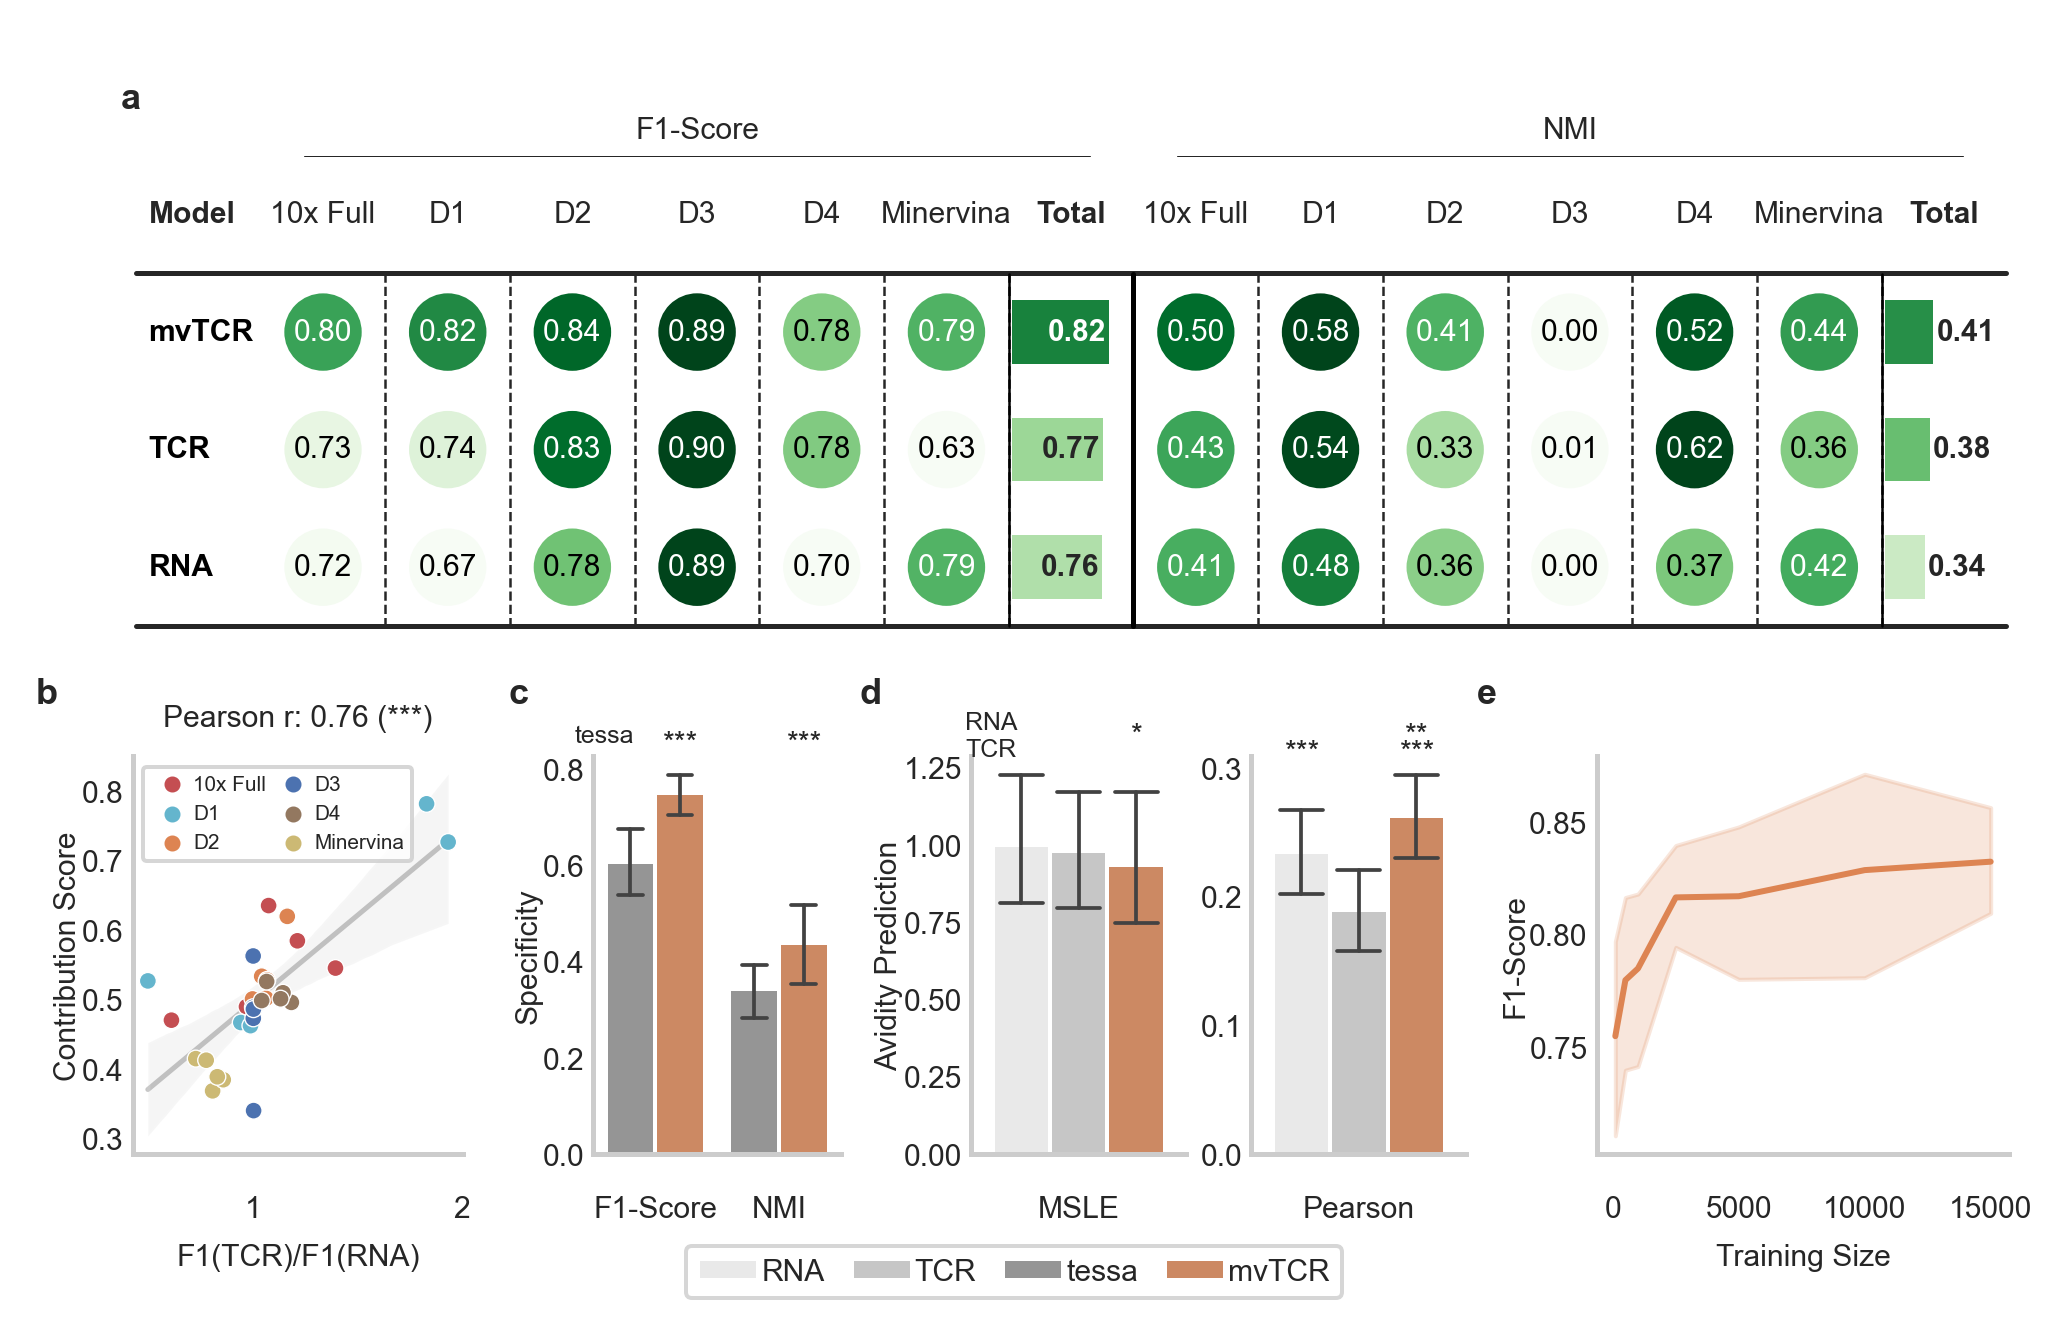

In [40]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.6),
                 dpi=DPI)
gridspecs = {}

# a a a a
# b c d e 

# a=Specificity, b=Characterstics, c=avididty
# d=size, e=tessa specificity, f=tessa characteristics

gridspecs["gs_abcde"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[1.5, 1.],
    width_ratios=[1],
    hspace=0.25,
)


gridspecs["gs_bcde"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_abcde"][1],
    nrows=1,
    ncols=4,
    width_ratios=[1, 0.75, 1.5, 1.25],
    wspace=0.35
)

gridspecs["gs_d"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_bcde"][2],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.3
)


axes = {}

axes['a'] = fig.add_subplot(gridspecs["gs_abcde"][0])
axes['b'] = fig.add_subplot(gridspecs["gs_bcde"][0])
axes['e'] = fig.add_subplot(gridspecs["gs_bcde"][1])
axes['d1'] = fig.add_subplot(gridspecs["gs_d"][0])
axes['d2'] = fig.add_subplot(gridspecs["gs_d"][1])
axes['c'] = fig.add_subplot(gridspecs["gs_bcde"][3])


plot_table(['mvTCR', 'TCR', 'RNA'], axes['a'])

axes['a'].axvline(7, ymin=0.01, ymax=0.6, linewidth=0.5, linestyle='-', color='black')
axes['a'].axvline(8, ymin=0.01, ymax=0.6, linewidth=1., linestyle='-', color='black')
axes['a'].axvline(14, ymin=0.01, ymax=0.6, linewidth=0.5, linestyle='-', color='black')

plot_scatter(results_contributions, 'F1(TCR)/F1(RNA)', 'Contribution Score', axes['b'])
plot_lineplot(data_size[data_size['size']<=15000], axes['c'], metrics=['F1-Score'])
plot_boxplot(data_avidity[data_avidity['metric']=='MSLE'], 
             ['RNA', 'TCR', 'mvTCR'], p_values_avd, axes['d1'], 
            ylabel='Avidity Prediction')
plot_boxplot(data_avidity[data_avidity['metric']=='Pearson'], 
             ['RNA', 'TCR', 'mvTCR'], p_values_avd, axes['d2'], 
            ylabel=None)

plot_boxplot(data_sota_spec, ['tessa', 'mvTCR'], p_values_sota_spec, axes['e'])


handles, labels = axes['b'].get_legend_handles_labels()
axes['b'].legend(handles[:-1], labels[:-1], #loc='lower center', bbox_to_anchor=(0.2, 0.8), 
                 frameon=True, ncol=2, markerscale=0.5,
                 handletextpad=0., columnspacing=0.3, fontsize='x-small')


handles_d, labels_d = axes['d1'].get_legend_handles_labels()
handles_e, labels_e = axes['e'].get_legend_handles_labels()

handles = handles_d[:-1] + handles_e
labels = labels_d[:-1] + labels_e

axes['d1'].legend(handles, labels, loc='lower center', ncol=4,  bbox_to_anchor=(0.2, -0.4), frameon=True, 
                  handletextpad=0.1, columnspacing=0.9)
#axes['e'].legend(loc='lower center', ncol=2,  bbox_to_anchor=(0.4, -0.4), frameon=True, 
#                 handletextpad=0.1, columnspacing=0.9)

#*axes['d'].get_legend_handles_labels()
#handles, labels = ax_legend.get_legend_handles_labels()
#ax_legend.legend(handles[3:], labels[3:], loc='upper center', ncol=3, bbox_to_anchor=(0.25, 1.2), frameon=True)


fig.text(0.12, 0.83, 'a', size='large', weight='bold')

fig.text(0.085, 0.42, 'b', size='large', weight='bold')
fig.text(0.28, 0.42, 'c', size='large', weight='bold')
fig.text(0.425, 0.42, 'd', size='large', weight='bold')
fig.text(0.68, 0.42, 'e', size='large', weight='bold')


fig.tight_layout()
fig.savefig('../figures/fig_benchmark.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/fig_benchmark.png',
           dpi=DPI, bbox_inches='tight')

In [41]:
data_size[data_size['metric']=='F1-Score'].groupby('size')['score'].mean()

size
100      0.754708
500      0.779653
1000     0.784861
2500     0.816501
5000     0.817025
10000    0.828648
15000    0.832404
Name: score, dtype: float64

## Supplementary
### Clonotype Compactness

PearsonRResult(statistic=-0.9550279936070046, pvalue=0.011370922885071124)


C:\Users\felix.drost\AppData\Local\Temp\ipykernel_13940\47401677.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


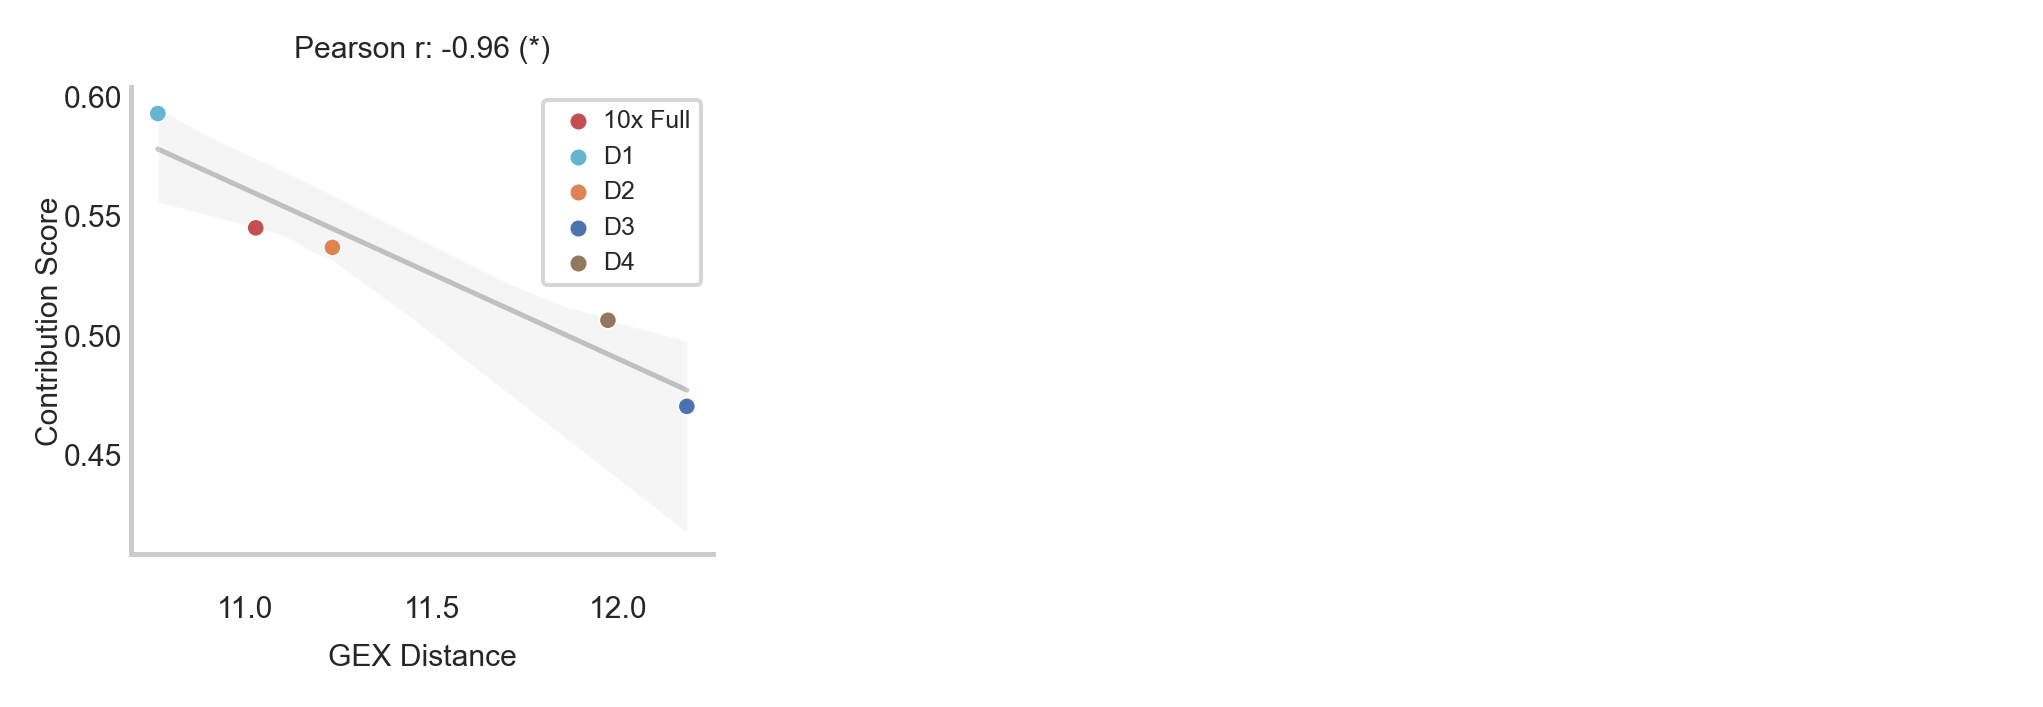

In [42]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.25),
                 dpi=DPI)
gridspecs = {}

# a b c

# a=Conservation Celltype, b=Conservation Clonotype, c=comparison Tessa

gridspecs["gs_ab"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 2],
    wspace=0.15,
)

axes['a'] = fig.add_subplot(gridspecs["gs_ab"][0])
axes['b'] = fig.add_subplot(gridspecs["gs_ab"][1])

plot_scatter(results_compactness, 'GEX Distance', 'Contribution Score', axes['a'])

handles, labels = axes['a'].get_legend_handles_labels()
axes['a'].legend(handles[:-1], labels[:-1], frameon=True, ncol=1, markerscale=0.5,
                 handletextpad=0., columnspacing=0.3, fontsize='small')
plot_empty(axes['b'])

#handles, labels = axes['b'].get_legend_handles_labels()
#axes['b'].legend(handles[2:], labels[2:], frameon=True, ncol=1, loc='right', bbox_to_anchor=(1.5, 1))


#fig.text(0.08, 0.86, 'a', size='large', weight='bold')
#fig.text(0.45, 0.86, 'b', size='large', weight='bold')
fig.tight_layout()
fig.savefig('../figures/suppl_ctCompact10x.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/suppl_ctCompact10x.png',
           dpi=DPI, bbox_inches='tight')

C:\Users\felix.drost\Anaconda3\envs\mvTCR_repro2\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_13940\1964134241.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


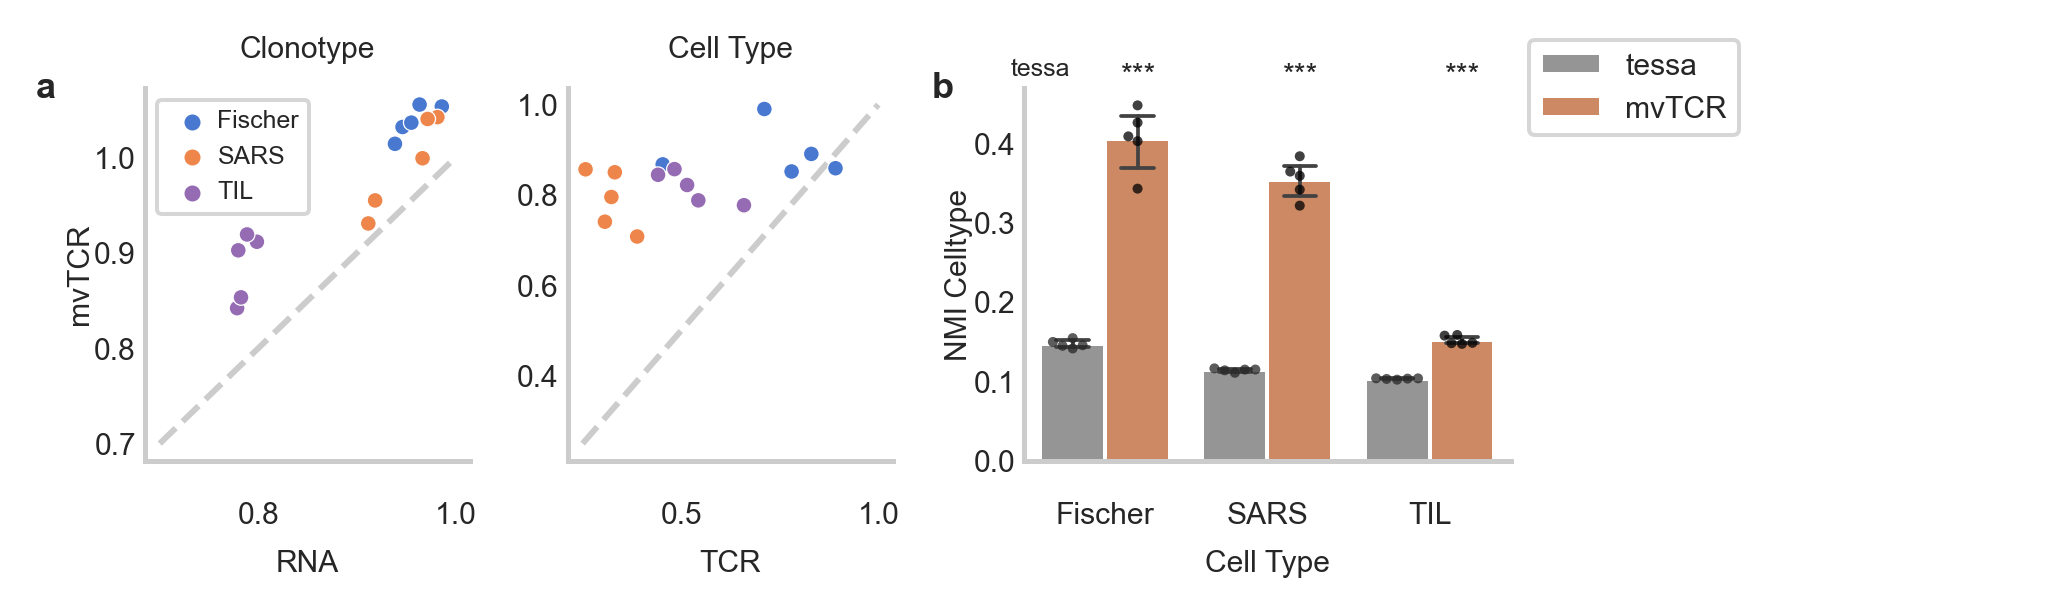

In [43]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.2),
                 dpi=DPI)
gridspecs = {}

# a b c

# a=Conservation Celltype, b=Conservation Clonotype, c=comparison Tessa

gridspecs["gs_abc"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1.5, 2],
    wspace=0.15,
)

gridspecs["gs_a"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_abc"][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.3
)

gridspecs["gs_bc"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_abc"][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.05
)

axes = {}

axes['a1'] = fig.add_subplot(gridspecs["gs_a"][0])
axes['a2'] = fig.add_subplot(gridspecs["gs_a"][1])
axes['b'] = fig.add_subplot(gridspecs["gs_bc"][0])
axes['c'] = fig.add_subplot(gridspecs["gs_bc"][1])


plot_scatter_conservation(data_char_norm, 'mvTCR', 'RNA', 'Clonotype', ax=axes['a1'])
plot_scatter_conservation(data_char_norm, 'mvTCR', 'TCR', 'Cell Type', ax=axes['a2'])

axes['a2'].set_ylabel(None)
axes['a2'].legend().remove()

axes['a1'].legend(frameon=True, ncol=1, markerscale=0.5,
                 handletextpad=0., columnspacing=0.3, fontsize='small')

plot_barplot_tessa(data_sota_char, ['tessa', 'mvTCR'], p_values_char_sota, 'Cell Type', axes['b'])
plot_empty(axes['c'])

handles, labels = axes['b'].get_legend_handles_labels()
axes['b'].legend(handles[2:], labels[2:], frameon=True, ncol=1, loc='right', bbox_to_anchor=(1.5, 1))


fig.text(0.08, 0.86, 'a', size='large', weight='bold')
fig.text(0.45, 0.86, 'b', size='large', weight='bold')


fig.tight_layout()
fig.savefig('../figures/suppFig_conservation.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/suppFig_conservation.png',
           dpi=DPI, bbox_inches='tight')

C:\Users\felix.drost\AppData\Local\Temp\ipykernel_13940\2670743735.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


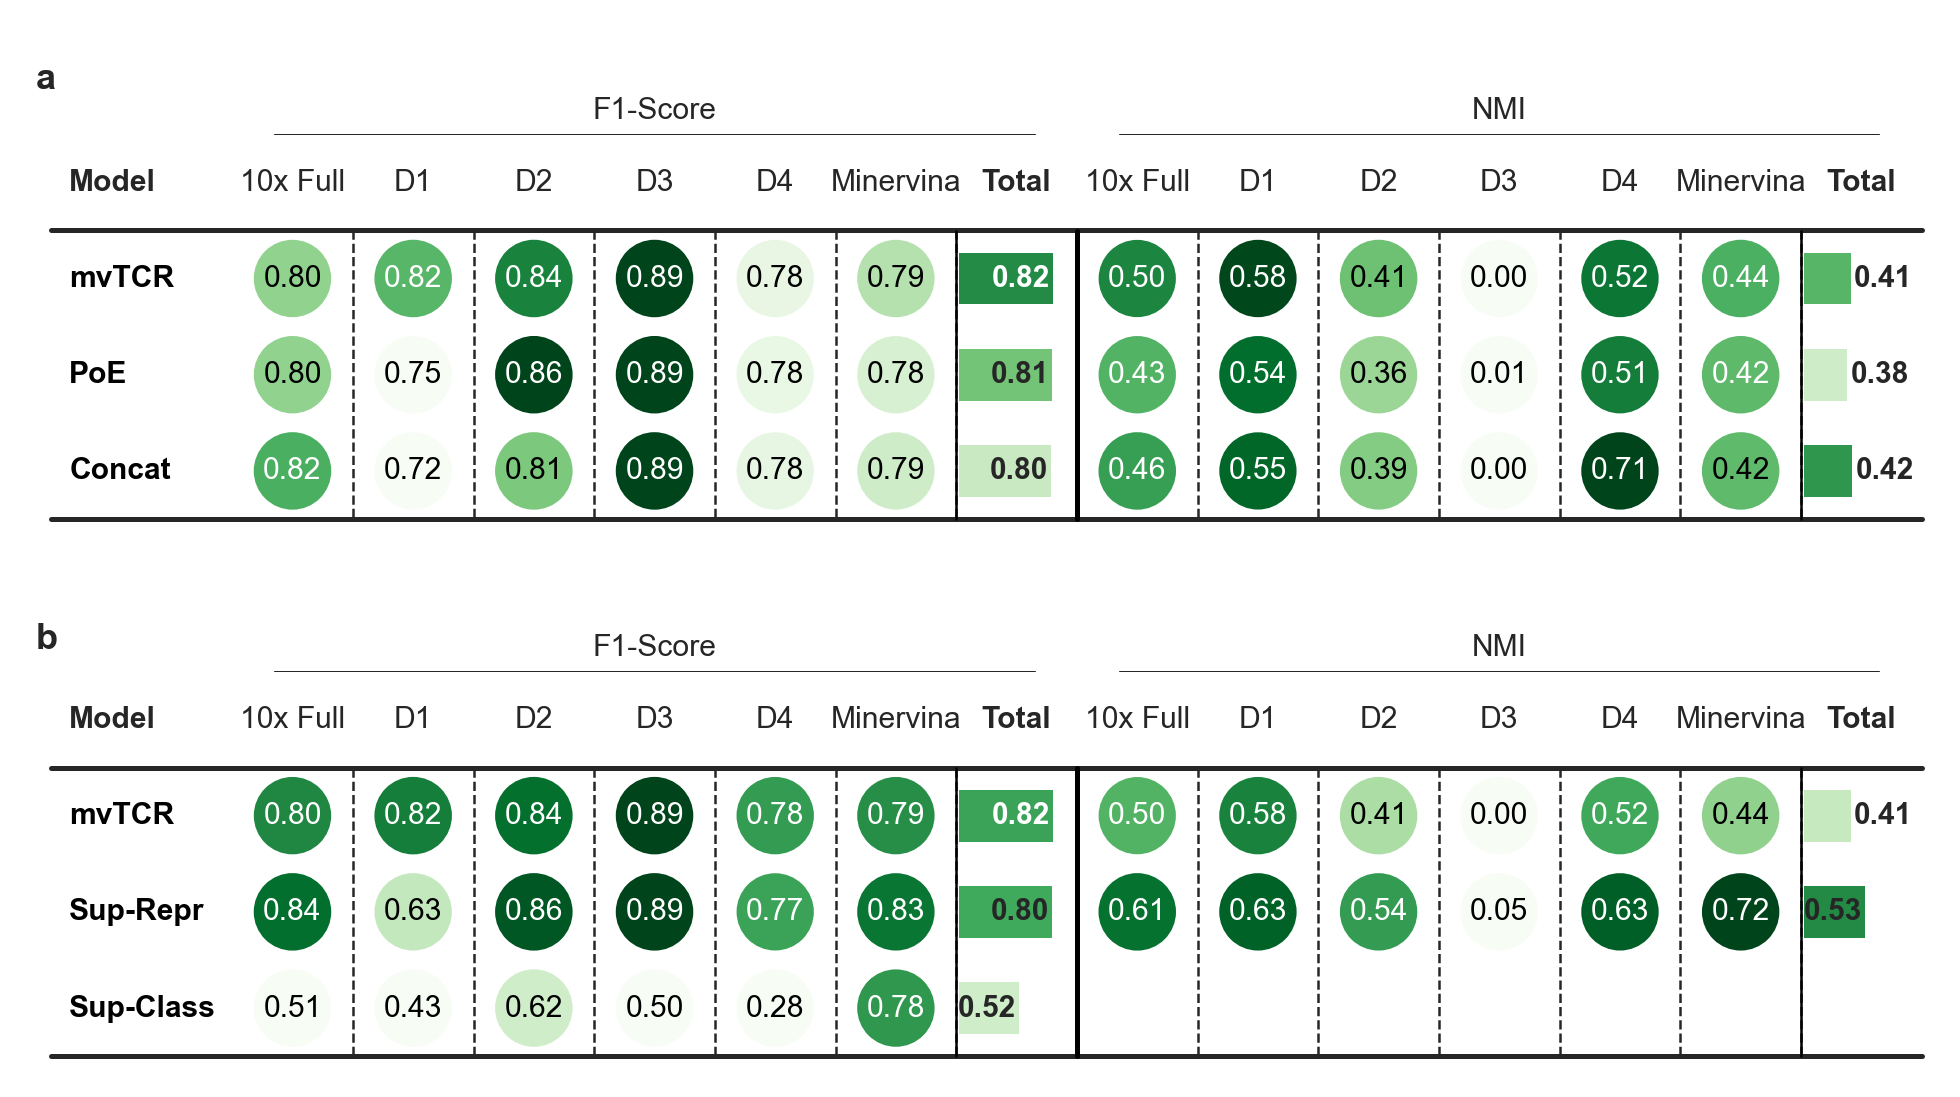

In [44]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.55),
                 dpi=DPI)
gridspecs = {}

# Table for PoE, MoE, Concat

gridspecs["gs_ab"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    width_ratios=[1],
    wspace=0.2,
    hspace=0.1
)

axes = {}

axes['a'] = fig.add_subplot(gridspecs["gs_ab"][0])
axes['b'] = fig.add_subplot(gridspecs["gs_ab"][1])

plot_table(['mvTCR', 'PoE', 'Concat'], axes['a'], space=1.5)
tab = plot_table(['mvTCR', 'Sup-Repr', 'Sup-Class'], axes['b'], space=1.5)

axes['a'].axvline(7.5, ymin=0.01, ymax=0.6, linewidth=0.5, linestyle='-', color='black')
axes['a'].axvline(8.5, ymin=0.01, ymax=0.6, linewidth=1., linestyle='-', color='black')
axes['a'].axvline(14.5, ymin=0.01, ymax=0.6, linewidth=0.5, linestyle='-', color='black')

axes['b'].axvline(7.5, ymin=0.01, ymax=0.6, linewidth=0.5, linestyle='-', color='black')
axes['b'].axvline(8.5, ymin=0.01, ymax=0.6, linewidth=1., linestyle='-', color='black')
axes['b'].axvline(14.5, ymin=0.01, ymax=0.6, linewidth=0.5, linestyle='-', color='black')

fig.text(0.12, 0.84, 'a', size='large', weight='bold')
fig.text(0.12, 0.42, 'b', size='large', weight='bold')


fig.tight_layout()
fig.savefig('../figures/suppFig_specificity_performance_other_models.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/suppFig_specificity_performance_other_models.png',
           dpi=DPI, bbox_inches='tight')

In [45]:
data_spec[data_spec['model'].str.contains('Sup') | (data_spec['model']=='mvTCR')
         ].groupby(['model', 'metric', 'donor'])['score'].mean()

model      metric    donor    
Sup-Class  F1-Score  10x Full     0.511023
                     D1           0.433624
                     D2           0.619305
                     D3           0.502285
                     D4           0.281554
                     Minervina    0.782709
Sup-Repr   F1-Score  10x Full     0.838415
                     D1           0.634888
                     D2           0.862995
                     D3           0.894674
                     D4           0.766906
                     Minervina    0.829400
           NMI       10x Full     0.609132
                     D1           0.629854
                     D2           0.541553
                     D3           0.052228
                     D4           0.633032
                     Minervina    0.720579
mvTCR      F1-Score  10x Full     0.804240
                     D1           0.817388
                     D2           0.836326
                     D3           0.894723
                     D4

In [71]:
data_spec[data_spec['model'].str.contains('Sup') | (data_spec['model']=='mvTCR')
         ].groupby(['model', 'metric'])['score'].mean()

model      metric  
Sup-Class  F1-Score    0.52175002
Sup-Repr   F1-Score    0.80454648
           NMI         0.53106274
mvTCR      F1-Score    0.82061751
           NMI         0.41046957
Name: score, dtype: float64

In [72]:
0.53106274-0.41046957

0.12059316999999997

C:\Users\felix.drost\Anaconda3\envs\mvTCR_repro2\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
C:\Users\felix.drost\Anaconda3\envs\mvTCR_repro2\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_13940\3856009893.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


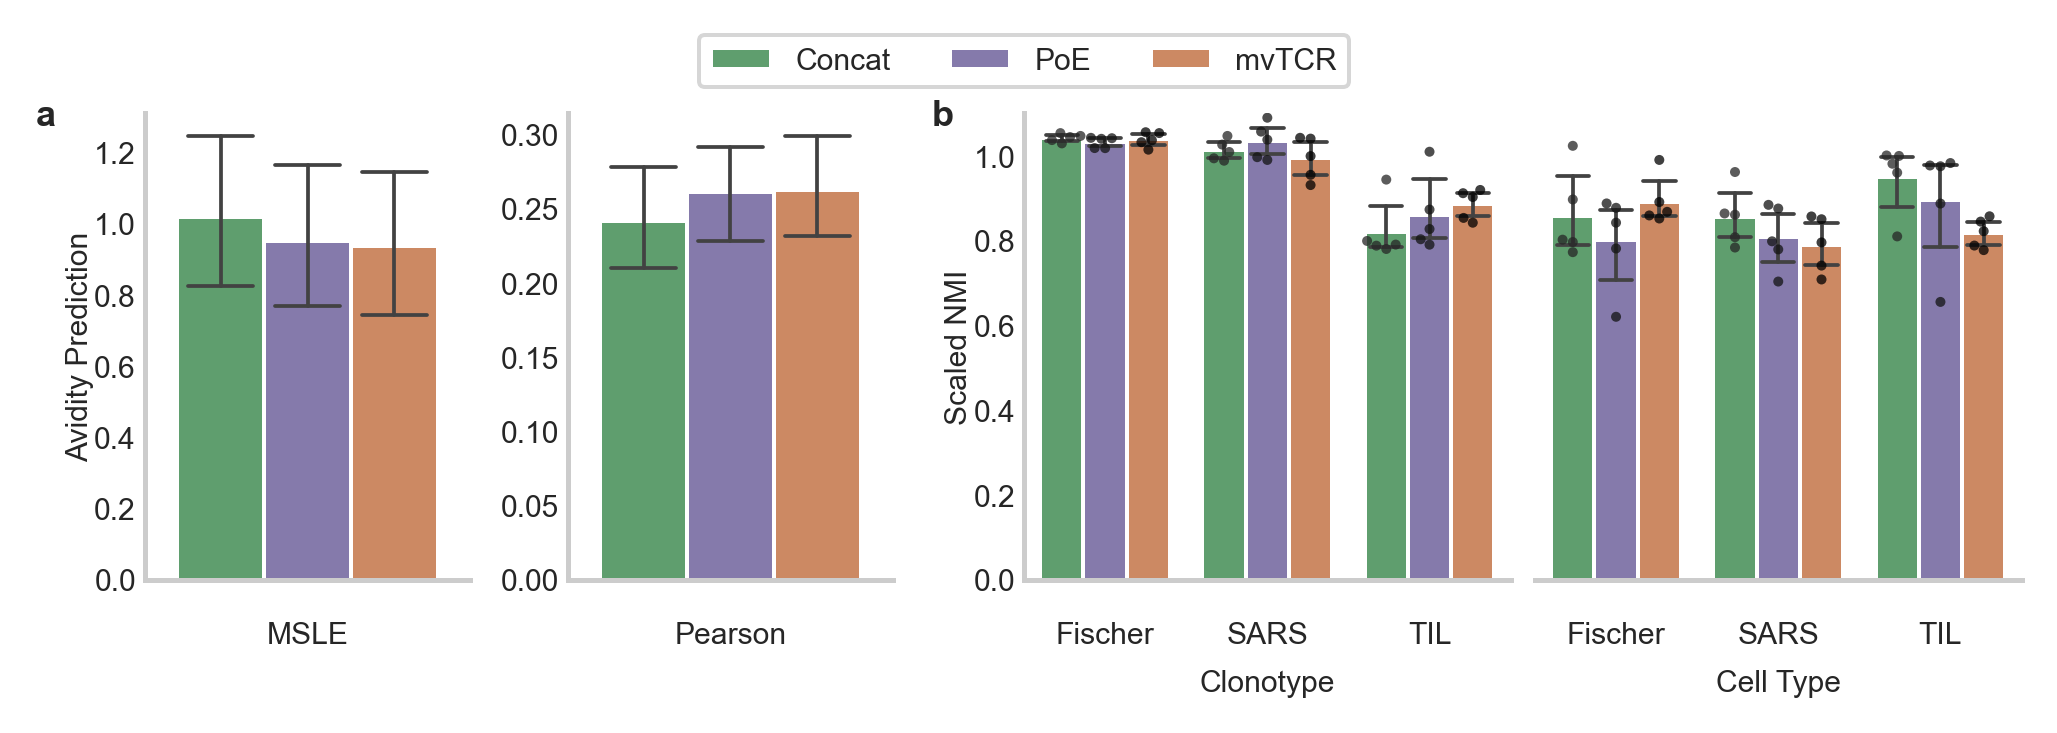

In [46]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.25),
                 dpi=DPI)
gridspecs = {}

# a b c c
# d d e f 

# a=Specificity, b=Characterstics, c=avididty
# d=size, e=tessa specificity, f=tessa characteristics

gridspecs["gs_abc"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1.5, 2],
    wspace=0.15,
)

gridspecs["gs_a"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_abc"][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.3
)

gridspecs["gs_bc"] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_abc"][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.05
)

axes = {}

axes['a1'] = fig.add_subplot(gridspecs["gs_a"][0])
axes['a2'] = fig.add_subplot(gridspecs["gs_a"][1])
axes['b'] = fig.add_subplot(gridspecs["gs_bc"][0])
axes['c'] = fig.add_subplot(gridspecs["gs_bc"][1])


plot_boxplot(data_avidity[data_avidity['metric']=='MSLE'], 
             ['mvTCR', 'Concat', 'PoE'], None, axes['a1'], 
            ylabel='Avidity Prediction')
plot_boxplot(data_avidity[data_avidity['metric']=='Pearson'], 
             ['mvTCR', 'Concat', 'PoE'], None, axes['a2'], 
            ylabel=None)

plot_barplot(data_char_norm, ['mvTCR', 'Concat', 'PoE'], None, axes['b'], axes['c'])

# Legend
ax_legend = axes['b']
handles, labels = ax_legend.get_legend_handles_labels()
ax_legend.legend(handles[3:], labels[3:], loc='upper center', ncol=3, bbox_to_anchor=(0., 1.2), frameon=True)

fig.text(0.08, 0.86, 'a', size='large', weight='bold')
fig.text(0.45, 0.86, 'b', size='large', weight='bold')


fig.tight_layout()
fig.savefig('../figures/suppFig_performance_other_models.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/suppFig_performance_other_models.png',
           dpi=DPI, bbox_inches='tight')

#### Future directions

In [47]:
data_adt = pd.read_csv('../results/performance_haniffa_adt.csv', index_col=0)
data_adt.columns = [el.lower() for el in data_adt.columns]
data_adt = data_adt.rename(columns={'value': 'score'})
data_adt = data_adt.replace({
    'NMI - Status_on_day_collection': 'Status',
    'NMI - full_clustering': 'Cell Type',
    'NMI - clonotype': 'Clonotype',
})
data_adt

,model,metric,score
0,mvTCR-ADT,Status,0.215798
1,mvTCR-ADT,Cell Type,0.291092
2,mvTCR-ADT,Clonotype,0.419018
3,mvTCR,Status,0.166058
4,mvTCR,Cell Type,0.300500
5,mvTCR,Clonotype,0.403337


In [48]:
df_dists = pd.read_csv(f'../results/performance_hamming_clusters.csv', index_col=0)
df_dists = df_dists.rename(columns={'Cluster': 'Hamming-\nClusters',
                                   'Random': 'Random\nClusters'})
df_dists.mean()

Hamming-\nClusters    11.601761
Random\nClusters      21.557965
dtype: float64

In [49]:
from scipy.stats import ttest_ind
def plot_violin(data, ax, palette=None):
    plot = sb.violinplot(data=data, palette=palette, ax=ax,
                        size=10, linewidth=0.75)
    ax.grid(False)
    sb.despine(ax=ax)
    ax.set_ylabel('Distance', labelpad=0)
    ax.tick_params('y', pad=-3)
    cols = data.columns
    pval = ttest_ind(data[cols[0]], data[cols[1]])[1]
    pval = p_2_sign(pval)
    if pval != "":
        ax.text(0.45, data.max().max()*1.1, pval, weight='bold')

C:\Users\felix.drost\Anaconda3\envs\mvTCR_repro2\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
C:\Users\felix.drost\AppData\Local\Temp\ipykernel_13940\2006778440.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


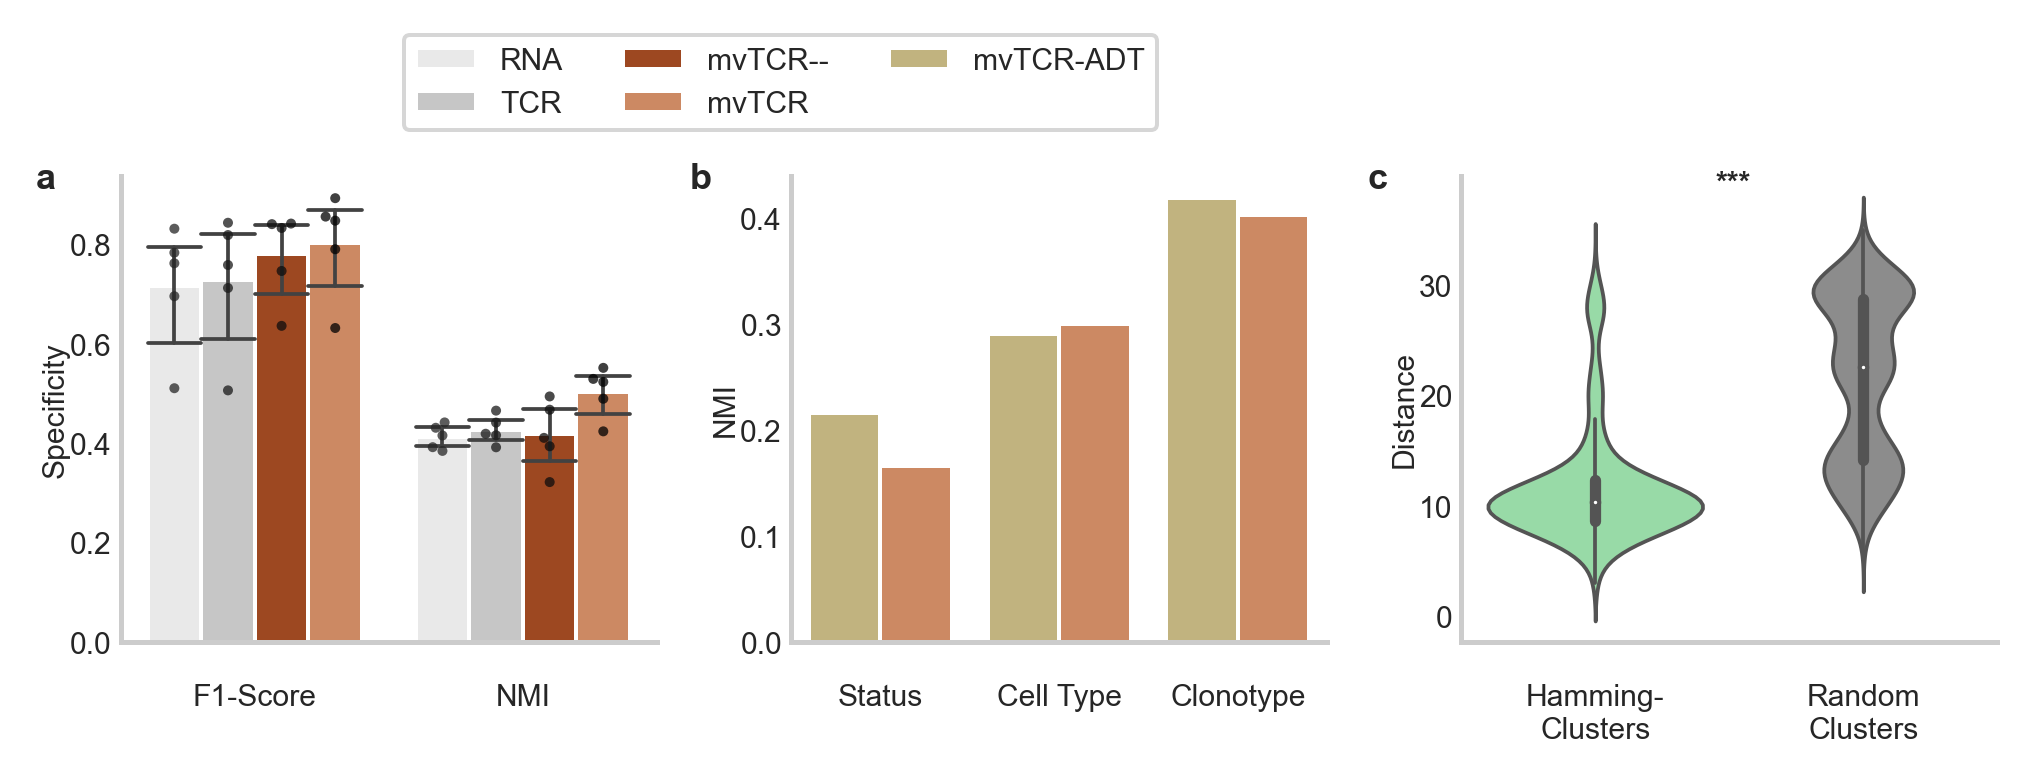

In [50]:
fig = plt.figure(figsize=(TEXT_WIDTH, TEXT_WIDTH * 0.25),
                 dpi=DPI)
gridspecs = {}

# a b c c
# d d e f 

# a=Specificity, b=Characterstics, c=avididty
# d=size, e=tessa specificity, f=tessa characteristics

gridspecs["gs_abc"] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=3,
    height_ratios=[1],
    width_ratios=[1, 1, 1],
    wspace=0.25,
)

axes = {}

axes['a'] = fig.add_subplot(gridspecs["gs_abc"][0])
axes['b'] = fig.add_subplot(gridspecs["gs_abc"][1])
axes['c'] = fig.add_subplot(gridspecs["gs_abc"][2])


plot_boxplot(data_10x_missing,
             ['mvTCR', 'mvTCR--', 'TCR', 'RNA'], None, axes['a'], 
            ylabel='Specificity', scatter=True)
plot_boxplot(data_adt, 
             ['mvTCR', 'mvTCR-ADT'], None, axes['b'],
            ylabel='NMI')
palette_hamming = {'Hamming-\nClusters': sb.color_palette('pastel')[2],
          'Random\nClusters': sb.color_palette('deep')[7]}
plot_violin(df_dists, axes['c'], palette_hamming)

# Legend
ax_legend = axes['a']
handles, labels = ax_legend.get_legend_handles_labels()
handles_2, labels_2 = axes['b'].get_legend_handles_labels()
ax_legend.legend(handles[4:]+handles_2[:1], labels[4:]+labels_2[:1], loc='center left', ncol=3, 
                 bbox_to_anchor=(0.5, 1.2), frameon=True)

fig.text(0.09, 0.86, 'a', size='large', weight='bold')
fig.text(0.36, 0.86, 'b', size='large', weight='bold')
fig.text(0.64, 0.86, 'c', size='large', weight='bold')

fig.tight_layout()
fig.savefig('../figures/suppFig_future.pdf',
           dpi=DPI, bbox_inches='tight')
fig.savefig('../figures/suppFig_future.png',
           dpi=DPI, bbox_inches='tight')

## Values for paper

### Specificity

In [51]:
data_spec.groupby(['metric', 'model'])['score'].mean()

metric    model    
F1-Score  Concat       0.801750
          PoE          0.811228
          RNA          0.759420
          Sup-Class    0.521750
          Sup-Repr     0.804546
          TCR          0.767430
          mvTCR        0.820618
NMI       Concat       0.422091
          PoE          0.379503
          RNA          0.339963
          Sup-Repr     0.531063
          TCR          0.381671
          mvTCR        0.410470
Name: score, dtype: float64

In [52]:
data_spec.groupby(['metric', 'donor', 'model'])['score'].mean()

metric    donor      model    
F1-Score  10x Full   Concat       0.820581
                     PoE          0.803629
                     RNA          0.717143
                     Sup-Class    0.511023
                     Sup-Repr     0.838415
                                    ...   
NMI       Minervina  PoE          0.422676
                     RNA          0.417318
                     Sup-Repr     0.720579
                     TCR          0.362396
                     mvTCR        0.440671
Name: score, Length: 78, dtype: float64

In [53]:
p_values_spec

,model,metric,RNA,TCR
0,Concat,F1-Score,0.048234,0.017900
1,mvTCR,F1-Score,0.001557,0.005062
2,PoE,F1-Score,0.015706,0.002327
3,TCR,F1-Score,0.399868,NaN
4,RNA,F1-Score,NaN,0.600132
5,Concat,NMI,0.000486,0.000013
6,mvTCR,NMI,0.000015,0.048431
7,PoE,NMI,0.001735,0.561905
8,TCR,NMI,0.022821,NaN
9,RNA,NMI,NaN,0.977179


### Data size

In [54]:
data_size[data_size['metric']=='F1-Score'].groupby(['metric', 'size'])['score'].mean()

metric    size 
F1-Score  100      0.754708
          500      0.779653
          1000     0.784861
          2500     0.816501
          5000     0.817025
          10000    0.828648
          15000    0.832404
Name: score, dtype: float64

### Avidity

In [55]:
data_avidity[data_avidity['metric'].isin(['Pearson', 'MSLE'])
            ].groupby(['metric', 'model'])['score'].mean()

metric   model 
MSLE     Concat    1.018164
         PoE       0.949731
         RNA       0.998525
         TCR       0.980359
         mvTCR     0.935638
Pearson  Concat    0.241668
         PoE       0.260842
         RNA       0.234307
         TCR       0.189197
         mvTCR     0.262707
Name: score, dtype: float64

In [56]:
p_values_avd

,model,metric,RNA,TCR
0,mvTCR,MSLE,0.045205,1.820731e-01
1,PoE,MSLE,0.038462,2.065436e-01
2,Concat,MSLE,0.741695,8.377819e-01
3,TCR,MSLE,0.353308,NaN
4,RNA,MSLE,NaN,6.466923e-01
5,mvTCR,Pearson,0.005954,3.242522e-10
6,PoE,Pearson,0.018688,1.279924e-08
7,Concat,Pearson,0.257033,7.119820e-06
8,TCR,Pearson,0.999374,NaN
9,RNA,Pearson,NaN,6.261188e-04


### Cell characteristic

In [57]:
data_char_norm.groupby(['dataset', 'model', 'metric'])['score'].mean()

dataset  model   metric   
Fischer  Concat  Cell Type    0.858224
                 Clonotype    1.042104
         PoE     Cell Type    0.801575
                 Clonotype    1.031949
         RNA     Cell Type    1.000000
                 Clonotype    0.957986
         TCR     Cell Type    0.733137
                 Clonotype    1.000000
         mvTCR   Cell Type    0.891932
                 Clonotype    1.038402
SARS     Concat  Cell Type    0.855514
                 Clonotype    1.012851
         PoE     Cell Type    0.807981
                 Clonotype    1.034310
         RNA     Cell Type    1.000000
                 Clonotype    0.950027
         TCR     Cell Type    0.321429
                 Clonotype    1.000000
         mvTCR   Cell Type    0.790263
                 Clonotype    0.993565
TIL      Concat  Cell Type    0.950270
                 Clonotype    0.820173
         PoE     Cell Type    0.895464
                 Clonotype    0.860567
         RNA     Cell Type    1.00000

In [58]:
data_char_norm.groupby(['model', 'metric'])['score'].mean()

model   metric   
Concat  Cell Type    0.888003
        Clonotype    0.958376
PoE     Cell Type    0.835006
        Clonotype    0.975609
RNA     Cell Type    1.000000
        Clonotype    0.897853
TCR     Cell Type    0.527659
        Clonotype    1.000000
mvTCR   Cell Type    0.833347
        Clonotype    0.972588
Name: score, dtype: float64

### SOTA

In [59]:
data_sota_spec.groupby(['model', 'metric'])['score'].mean()

model  metric  
mvTCR  F1-Score    0.750511
       NMI         0.438416
tessa  F1-Score    0.607004
       NMI         0.343186
Name: score, dtype: float64

In [60]:
data_sota_spec.groupby(['metric', 'donor', 'model'])['score'].mean()

metric    donor      model
F1-Score  10x Full   mvTCR    0.695971
                     tessa    0.383015
          D1         mvTCR    0.636430
                     tessa    0.612362
          D2         mvTCR    0.758192
                     tessa    0.639023
          D3         mvTCR    0.890114
                     tessa    0.882810
          D4         mvTCR    0.744325
                     tessa    0.658715
          Minervina  mvTCR    0.778035
                     tessa    0.466099
NMI       10x Full   mvTCR    0.501714
                     tessa    0.357783
          D1         mvTCR    0.592967
                     tessa    0.507457
          D2         mvTCR    0.366572
                     tessa    0.382795
          D3         mvTCR    0.004608
                     tessa    0.020899
          D4         mvTCR    0.722175
                     tessa    0.483627
          Minervina  mvTCR    0.442462
                     tessa    0.306553
Name: score, dtype: float64

In [61]:
pd.set_option("display.precision", 8)
p_values_sota_spec

,model,metric,tessa
0,mvTCR,F1-Score,0.00000467
1,tessa,F1-Score,NaN
2,mvTCR,NMI,0.00000462
3,tessa,NMI,NaN


In [62]:
get_p_values(data_sota_char, 
            baselines=['tessa'], sortby=['dataset', 'split'])


,model,metric,tessa
0,mvTCR,Cell Type,0.00000307
1,tessa,Cell Type,NaN
2,mvTCR,Clonotype,1.00000000
3,tessa,Clonotype,NaN


In [63]:
data_sota_char.groupby(['model', 'metric', 'dataset'])['score'].mean()

model  metric     dataset
mvTCR  Cell Type  Fischer    0.40560599
                  SARS       0.35398081
                  TIL        0.15181975
       Clonotype  Fischer    0.81104227
                  SARS       0.77265119
                  TIL        0.75557189
tessa  Cell Type  Fischer    0.14700761
                  SARS       0.11396274
                  TIL        0.10304901
       Clonotype  Fischer    0.88583627
                  SARS       0.86913953
                  TIL        0.87861717
Name: score, dtype: float64

In [64]:
data_sota_char.groupby(['metric', 'model'])['score'].mean()

metric     model
Cell Type  mvTCR    0.30380218
           tessa    0.12133979
Clonotype  mvTCR    0.77975511
           tessa    0.87786433
Name: score, dtype: float64

In [65]:
data_spec.groupby(['metric', 'donor',  'model'])['score'].mean()

metric    donor      model    
F1-Score  10x Full   Concat       0.82058115
                     PoE          0.80362942
                     RNA          0.71714329
                     Sup-Class    0.51102277
                     Sup-Repr     0.83841548
                                     ...    
NMI       Minervina  PoE          0.42267553
                     RNA          0.41731756
                     Sup-Repr     0.72057851
                     TCR          0.36239612
                     mvTCR        0.44067148
Name: score, Length: 78, dtype: float64

In [66]:
get_p_values(data_spec[data_spec['model'].isin(['RNA', 'TCR', 'mvTCR'])], 
             baselines=['RNA', 'TCR'], sortby=['donor', 'split'])

,model,metric,RNA,TCR
0,mvTCR,F1-Score,0.00155736,0.00506204
1,TCR,F1-Score,0.39986778,NaN
2,RNA,F1-Score,NaN,0.60013222
3,mvTCR,NMI,0.00001496,0.04843055
4,TCR,NMI,0.02282089,NaN
5,RNA,NMI,NaN,0.97717911


In [67]:
data_spec.groupby(['donor', 'metric', 'model'])['score'].mean()

donor      metric    model    
10x Full   F1-Score  Concat       0.82058115
                     PoE          0.80362942
                     RNA          0.71714329
                     Sup-Class    0.51102277
                     Sup-Repr     0.83841548
                                     ...    
Minervina  NMI       PoE          0.42267553
                     RNA          0.41731756
                     Sup-Repr     0.72057851
                     TCR          0.36239612
                     mvTCR        0.44067148
Name: score, Length: 78, dtype: float64

In [68]:
data_spec.groupby(['metric', 'model'])['score'].mean()

metric    model    
F1-Score  Concat       0.80174996
          PoE          0.81122807
          RNA          0.75942043
          Sup-Class    0.52175002
          Sup-Repr     0.80454648
          TCR          0.76743035
          mvTCR        0.82061751
NMI       Concat       0.42209109
          PoE          0.37950348
          RNA          0.33996250
          Sup-Repr     0.53106274
          TCR          0.38167128
          mvTCR        0.41046957
Name: score, dtype: float64

### Missing values

In [69]:
data_10x_missing.groupby(['model', 'metric'])['score'].mean()

model    metric  
RNA      F1-Score    0.71714329
         NMI         0.41332840
TCR      F1-Score    0.72837765
         NMI         0.42712832
mvTCR    F1-Score    0.80423974
         NMI         0.50391400
mvTCR--  F1-Score    0.78017034
         NMI         0.41791318
Name: score, dtype: float64

## Save p-values

In [70]:
path_out = '../results/supplement/S1_benchmarking.xlsx'

with pd.ExcelWriter(path_out, mode='a', if_sheet_exists='replace') as writer:
    p_values_spec.to_excel(writer, sheet_name='StatsSpecificity')
    p_values_avd.to_excel(writer, sheet_name='StatsAvidity')
    p_values_sota_spec.to_excel(writer, sheet_name='StatsSpecificitySota')
    p_values_char.to_excel(writer, sheet_name='StatsCharacteristics')
    p_values_char_sota.to_excel(writer, sheet_name='StatsCharacteristicsSota')